# Getting Started


<div class="alert alert-block alert-info">
<b>Tip:</b> The newer JupyterLab as opposed to the older Jupyter Notebook uses a different framework for widgets which is currently not compatible with the widgets used in PyZX. It is therefore recommended that you use the classic notebook interface. If you are using JupyterLab you can find this interface by going to 'Help -> Launch Classic Notebook'.
</div>


We start by importing the library and configuring matplotlib to display the figures in a nice way.

In [50]:
import sys; sys.path.insert(0, '../..') # So that we import the local copy of pyzx if you have installed from Github
import random
import pyzx as zx

Quantum circuits in PyZX are represented by the `pyzx.circuit.Circuit` class. Files in the supported formats (QASM, QC, Quipper) can easily be imported into PyZX as shown below.

In [51]:
circuit_import = zx.Circuit.load("../../circuits/Arithmetic_and_Toffoli/adder_8_after_heavy")


PyZX tries to automatically figure out in which format the circuit is represented. The `pyzx.generate` module supplies several ways to generate random circuits. For example we can create a new random circuit and visualize it 

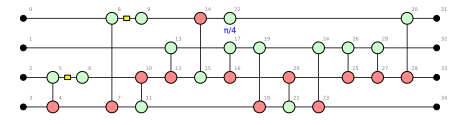

In [52]:
qubit_amount = 4
depth = 15
circ = zx.generate.CNOT_HAD_PHASE_circuit(qubit_amount, depth)
zx.draw_matplotlib(circ,labels=True,h_edge_draw='box') 

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

If you are running inside a Jupyter notebook, circuits can be easily visualized using the zx.draw() function.

This draw function by default uses the D3 Javascript library to draw the diagram. If it doesn't work, use draw_matplotlib() as shown above instead.  When not running in a Jupyter notebook `zx.draw` returns a matplotlib figure instead. 

In [53]:
zx.draw(circ, labels=True)

Notice that the blue lines represent edges that have a Hadamard gate on them.


There are two main data structures in PyZX, Circuits and Graphs. A `pyzx.circuit.Circuit` is essentially just a list of gates. The above is an example of a ``Circuit``

In [54]:
print (circ.gates)

[CNOT(2,3), HAD(2), CNOT(0,3), HAD(0), CNOT(3,2), CNOT(1,2), CNOT(2,0), CNOT(1,2), CNOT(1,3), CNOT(3,2), T(0), CNOT(1,3), CNOT(1,2), CNOT(1,2), CNOT(0,2)]


Most of the functionality in PyZX works on Graphs instead, which directly represent ZX-diagrams (the drawing function ``zx.draw`` above for instance first converted the circuit into a Graph before drawing it). ZX-diagrams are represented by instances of `BaseGraph`. 

To convert a circuit into a ZX-diagram, simply do:


In [55]:
graph = circ.to_graph()

Internally, a ZX-diagram is just a graph with some additional data:

In [56]:
print(graph)
print("All edges: ", list(graph.edges()))
print("\nThe neighbors of a particular vertex: ", list(graph.neighbors(14)))

Graph(35 vertices, 43 edges)
All edges:  [(0, 8), (1, 13), (2, 5), (3, 4), (4, 5), (4, 7), (5, 6), (6, 10), (7, 8), (7, 11), (8, 9), (9, 14), (10, 11), (10, 12), (11, 18), (12, 13), (12, 15), (13, 17), (14, 15), (14, 22), (15, 16), (16, 17), (16, 20), (17, 19), (18, 19), (18, 21), (19, 24), (20, 21), (20, 25), (21, 23), (22, 30), (23, 24), (23, 34), (24, 26), (25, 26), (25, 27), (26, 28), (27, 28), (27, 29), (28, 32), (29, 30), (29, 33), (30, 31)]

The neighbors of a particular vertex:  [9, 15, 22]


We can generate a ZX-diagrams directly, instead of needing to convert from a circuit, by using a different generator function:

In [57]:
circ = zx.generate.cliffords(qubit_amount, depth)
zx.draw(circ)

Using this graph representation we can use the rules of the ZX-calculus to simplify it:

In [58]:
g = circ.copy()
zx.clifford_simp(g)

True

In [59]:
g.normalize() # Reposition nodes horizontally to look nicer
zx.draw(g)

Let's try to see in a bit more detail what goes into rewriting this circuit.

In [60]:
from pyzx.simplify import *

g = circ.copy()
graphs = [zx.draw_matplotlib(graph)]
names = ["start"]

s = spider_simp(g)
if s: zx.draw(g)

to_gh(g)
zx.draw(g)
while True:
    while True:
        i1 = id_simp(g)
        i2 = spider_simp(g)
        i3 = pivot_simp(g)
        if i1 or i2 or i3: zx.draw(g)

        i4 = lcomp_simp(g)
        if i4: zx.draw(g)

        if not (i1 or i2 or i3 or i4): break

    i2 = pivot_boundary_simp(g)
    if i2: zx.draw(g)
    if not i2: break


As you can see, the first few steps are **spider fusion**, where adjacent red nodes and adjacent green nodes are fused together (and their phases added). This step also removes parallel edges between red and green nodes. The next step is to convert all red nodes to green nodes by changing regular edges to hadamard edges.

Now come the steps that do most of the work. These steps are a round of **pivots** followed by **local complementations** and then a round of pivots again. The local complementation rules looks for green nodes with a phase of $\frac\pi2$ or $\frac{3\pi}2$. By doing a local complementation on this node we can remove the node from the graph. This process is done until no more suitable candidates are found. A pivot consists of a series of three local complementations that is done on two neighboring vertices that have a zero or $\pi$ phase. A pivot move allows us to remove these two nodes.

Finally we do a round of **identity** simplification which removes phaseless nodes that are connected to precisely two neighbors.

**Note**: Depending on the circuit that was generated, any of these steps might not have been done.

Even though this graph is a lot compacter than the one we started out with, it no longer looks like a circuit. To fix this we need to be clever and *extract* a circuit from the ZX-diagram:

In [61]:
circ2 = g.copy()
circ2.normalize()
circ2 = zx.extract_circuit(circ2)
zx.draw(circ2)

To verify that this circuit is still equal to the original circuit, we can transform them into numpy tensors and compare these tensors for equality:

In [62]:
t1 = circ.to_tensor()
t2 = circ2.to_tensor()
# This checks whether t1 and t2 are equal up to some number: t1 == z*t2 for some complex number z
zx.compare_tensors(t1,t2,preserve_scalar=False)

True

This extraction procedure is sometimes not as good at keeping the number of two-qubit gates low, and will sometimes increase the size of the circuit. PyZX also supplies some Circuit-level optimisers that more consistently reduce the size of the circuit (but are less powerful):

In [63]:
c2 = zx.optimize.basic_optimization(circ2.to_basic_gates())
zx.draw(c2)

We can represent the circuit in one of several quantum circuit description languages, such as that of QASM:

In [64]:
print(circ2.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[3];
h q[2];
h q[0];
h q[2];
cz q[0], q[2];
rz(0.5*pi) q[0];
h q[3];
h q[0];
cz q[2], q[3];
cz q[0], q[2];
h q[2];
cz q[1], q[2];
rz(1.5*pi) q[3];
h q[3];
h q[1];
cz q[2], q[3];
cz q[0], q[3];
cz q[0], q[2];
rz(1.0*pi) q[3];
h q[3];
h q[0];



Now lets try the same thing with a more complicated Clifford+T circuit.

In [65]:
qubit_amount = 6
depth = 70
random.seed(1338)
circ = zx.generate.cliffordT(qubit_amount, depth,p_t=0.2)
zx.draw(circ)

In [66]:
g = circ.copy()
zx.clifford_simp(g)
g.normalize()
zx.draw(g)

Again, let us extract a circuit from this diagram:

In [67]:
g2 = g.copy()
c = zx.extract_circuit(g2)
print(c.stats())

Circuit  on 6 qubits with 62 gates.
        8 is the T-count
        54 Cliffords among which
        28 2-qubit gates (2 CNOT, 26 other) and
        22 Hadamard gates.


We can convert this back into a PyZX-graph:

In [68]:
zx.draw(c.to_graph())

And verify that it is still equal to the original graph:

In [69]:
# We can just feed the Circuit objects directly to compare_tensors
zx.compare_tensors(c, circ)

True

Now lets represent this circuit in the QASM circuit description language:

In [70]:
print(c.to_basic_gates().to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
cx q[2], q[5];
cx q[5], q[2];
cx q[2], q[5];
cx q[1], q[4];
cx q[4], q[1];
cx q[1], q[4];
h q[5];
h q[4];
h q[3];
h q[1];
h q[1];
h q[3];
cz q[2], q[5];
cz q[2], q[3];
cz q[1], q[2];
h q[2];
h q[5];
cz q[2], q[5];
cz q[2], q[3];
cz q[1], q[2];
rz(1.25*pi) q[2];
h q[0];
h q[2];
h q[4];
cz q[1], q[5];
cz q[1], q[4];
cz q[1], q[3];
cz q[1], q[2];
cz q[0], q[1];
rz(0.5*pi) q[1];
h q[1];
cz q[1], q[3];
rz(1.5*pi) q[3];
h q[3];
cz q[0], q[5];
cz q[0], q[4];
cz q[0], q[3];
h q[0];
cx q[0], q[2];
cz q[3], q[5];
cz q[2], q[5];
cz q[0], q[5];
rz(0.75*pi) q[5];
h q[5];
rz(1.25*pi) q[5];
h q[5];
cx q[5], q[1];
cz q[2], q[3];
rz(1.25*pi) q[2];
h q[2];
cz q[0], q[3];
cz q[0], q[2];
rz(0.75*pi) q[4];
rz(0.25*pi) q[0];
h q[4];
h q[0];
cz q[3], q[5];
cz q[3], q[4];
cz q[1], q[5];
rz(0.5*pi) q[5];
h q[5];
rz(0.75*pi) q[4];
rz(0.25*pi) q[3];
h q[2];
rz(0.5*pi) q[0];
h q[0];



Optimizing random circuits might not be very useful, so lets look at an optimization on a predefined circuit:

In [71]:
c = zx.Circuit.load('../../circuits/Fast/mod5_4_before')  # Circuit.load auto-detects the file format
print(c.gates)  #  This circuit is built out of CCZ gates.
zx.draw(c)

[NOT(4), HAD(4), CCZ(c1=0,c2=3,t=4), CCZ(c1=2,c2=3,t=4), HAD(4), CNOT(3,4), HAD(4), CCZ(c1=1,c2=2,t=4), HAD(4), CNOT(2,4), HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4), CNOT(1,4), CNOT(0,4)]


In [72]:

c = c.to_basic_gates()  #  Convert it to the Clifford+T gate set.
print(c.gates)
print(c.stats())
zx.draw(c)

[NOT(4), HAD(4), CNOT(3,4), T*(4), CNOT(0,4), T(4), CNOT(3,4), T*(4), CNOT(0,4), T(3), T(4), CNOT(0,3), T(0), T*(3), CNOT(0,3), CNOT(3,4), T*(4), CNOT(2,4), T(4), CNOT(3,4), T*(4), CNOT(2,4), T(3), T(4), CNOT(2,3), T(2), T*(3), CNOT(2,3), HAD(4), CNOT(3,4), HAD(4), CNOT(2,4), T*(4), CNOT(1,4), T(4), CNOT(2,4), T*(4), CNOT(1,4), T(2), T(4), CNOT(1,2), T(1), T*(2), CNOT(1,2), HAD(4), CNOT(2,4), HAD(4), CNOT(1,4), T*(4), CNOT(0,4), T(4), CNOT(1,4), T*(4), CNOT(0,4), T(1), T(4), CNOT(0,1), T(0), T*(1), CNOT(0,1), HAD(4), CNOT(1,4), CNOT(0,4)]
Circuit mod5_4_before on 5 qubits with 63 gates.
        28 is the T-count
        35 Cliffords among which
        28 2-qubit gates (28 CNOT, 0 other) and
        6 Hadamard gates.


In [73]:
g = c.to_graph()
zx.simplify.full_reduce(g)  # Simplify the ZX-graph
print(g)
zx.draw(g)


Graph(31 vertices, 46 edges)


In [74]:
c2 = zx.extract_circuit(g).to_basic_gates()  # Turn graph back into circuit
print(c2.stats())
zx.draw(c2)


Circuit  on 5 qubits with 62 gates.
        8 is the T-count
        54 Cliffords among which
        28 2-qubit gates (6 CNOT, 22 other) and
        24 Hadamard gates.


In [75]:

c3 = zx.optimize.full_optimize(c2)  #  Do some further optimization on the circuit
print(c3.stats())
zx.draw(c3)


Circuit  on 5 qubits with 31 gates.
        8 is the T-count
        23 Cliffords among which
        18 2-qubit gates (16 CNOT, 2 other) and
        2 Hadamard gates.


PyZX can also be run from the command-line for some easy circuit-to-circuit manipulation. In order to optimize a circuit you can run the command 

`python -m pyzx opt input_circuit.qasm`

For more information regarding the command-line tools, run ``python -m pyzx --help``.

This concludes this tutorial. For more information about the simplification procedures see [Simplify](simplify.ipynb). The different representations of the graphs and circuits as well as how to create and modify ZX-diagrams are detailed in the other tuorial notebooks.
